In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import image
from matplotlib import pyplot

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sb
#from keras.preprocessing.image import ImageDataGenerator, load_img
#from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("./archive/garbage classification/Garbage classification//"))

['trash', 'glass', 'plastic', 'paper', 'cardboard', 'metal']


In [4]:
trash = pd.read_csv("./archive//zero-indexed-files.txt")
trash

,glass1.jpg 0
0,glass2.jpg 0
1,glass3.jpg 0
2,glass4.jpg 0
3,glass5.jpg 0
4,glass6.jpg 0
...,...
2521,trash133.jpg 5
2522,trash134.jpg 5
2523,trash135.jpg 5
2524,trash136.jpg 5


In [5]:
category = []
filename = []
with open("./archive/zero-indexed-files.txt", "r") as file:
    for line in file:     
        cat = ''.join([i for i in line.split('.')[0] if not i.isdigit()])
        category.append(cat)
        
        filename.append(cat+"/"+line.split(' ')[0])

df = pd.DataFrame({
    'filename':filename,
    'category': category,
})

df

,filename,category
0,glass/glass1.jpg,glass
1,glass/glass2.jpg,glass
2,glass/glass3.jpg,glass
3,glass/glass4.jpg,glass
4,glass/glass5.jpg,glass
...,...,...
2522,trash/trash133.jpg,trash
2523,trash/trash134.jpg,trash
2524,trash/trash135.jpg,trash
2525,trash/trash136.jpg,trash


<AxesSubplot:title={'center':'Count plot'}, xlabel='category', ylabel='count'>

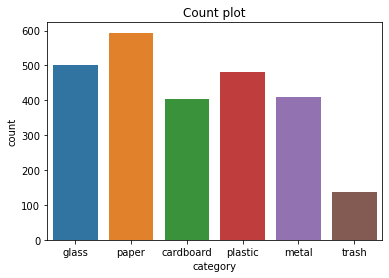

In [6]:
plt.title('Count plot')
sb.countplot(x = df['category'], data=df)
#Index 0: glass, Index 1: paper, Index 2: cardboard, Index 3: plastic, Index 4: metal, Index 5: other

Numpy array of the image is:  [[[208 210 222]
  [208 210 222]
  [208 210 222]
  ...
  [162 162 174]
  [162 162 174]
  [162 162 174]]

 [[208 210 222]
  [208 210 222]
  [208 210 222]
  ...
  [162 162 174]
  [162 162 174]
  [162 162 174]]

 [[208 210 222]
  [208 210 222]
  [208 210 222]
  ...
  [162 162 174]
  [162 162 174]
  [162 162 174]]

 ...

 [[212 212 224]
  [211 211 223]
  [211 211 223]
  ...
  [184 182 193]
  [184 182 193]
  [184 182 193]]

 [[212 212 224]
  [212 212 224]
  [211 211 223]
  ...
  [184 182 193]
  [184 182 193]
  [184 182 193]]

 [[212 212 224]
  [212 212 224]
  [212 212 224]
  ...
  [184 182 193]
  [184 182 193]
  [184 182 193]]]


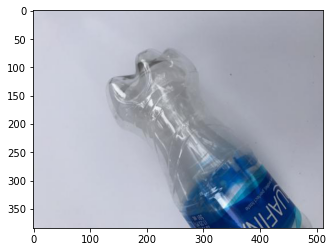

In [88]:
# open image to numpy array and switch to RGB from BGR
# load image as pixel array
from matplotlib import pyplot
sample = random.choice(filename)
folder = ''.join([i for i in sample.split('.')[0] if not i.isdigit()])
image = pyplot.imread('archive/garbage classification/Garbage classification/'+sample)
# summarize shape of the pixel array
print("Numpy array of the image is: ", image)
# display the array of pixels as an image
pyplot.imshow(image)
pyplot.show()